In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#Make sure mmc repository is in pythonpath
import sys
sys.path.append('/home/dallaert/tools/a2e-mmc/')

In [4]:
from mmctools.helper_functions import calc_wind, theta, power_spectral_density
from mmctools.plotting import plot_timeheight, plot_timehistory_at_height, plot_profile, plot_spectrum

In [5]:
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16

# Demonstrate plotting library

## Load data

Load a processed TTU dataset for demonstration purposes. The dataset can be obtained by running the notebook "process_TTU_tower.ipynb" which can be found in the [a2e-mmc/assessment repository](https://github.com/a2e-mmc/assessment) (currently only in the dev branch)

In [6]:
datadir = './'
TTUdata = 'TTU_tilt_corrected_20131108-09.csv'

In [7]:
df = pd.read_csv(os.path.join(datadir,TTUdata),parse_dates=True,index_col=['datetime','height'])
df.head()

u         v         w          Ts        T      RH  \
datetime   height                                                              
2013-11-08 0.9    -0.138929  2.637817  0.074016  289.410000  284.794  26.186   
           2.4    -0.601111  2.783204  0.487330  290.979994  284.932  25.810   
           4.0     0.416792  4.043940  0.295800  287.520000  285.166  25.380   
           10.1   -0.276479  5.227110 -0.418065  287.250000  285.298  25.264   
           16.8    0.034364  5.908367 -0.173836  287.610000  285.414  24.934   

                            p  
datetime   height              
2013-11-08 0.9     908.547754  
           2.4     908.723508  
           4.0     908.215548  
           10.1    907.611414  
           16.8    907.307654

Do some additional data processing

In [8]:
# Calculate wind speed and direction
df['wspd'], df['wdir'] = calc_wind(df)
df['theta'] = theta(df['T'],df['p'])

In [9]:
# Calculate 10min averages and recompute wind speed and wind direction
df10 = df.unstack().resample('10min').mean().stack()
df10['wspd'], df10['wdir'] = calc_wind(df10)

Calculate spectra

In [10]:
%time df_spectra = power_spectral_density(df.xs(74.7,level='height'),tstart=pd.to_datetime('2013-11-08 12:00:00'),interval='1h')
df_spectra['datetime']=pd.to_datetime('2013-11-08 12:00:00')
df_spectra = df_spectra.set_index(['datetime','frequency'])
df_spectra.head()
# CPU times: user 1min 6s, sys: 2.91 s, total: 1min 9s
# Wall time: 1min 9s

CPU times: user 40.4 ms, sys: 205 µs, total: 40.6 ms
Wall time: 40.1 ms


u         v         w        Ts  \
datetime            frequency                                           
2013-11-08 12:00:00 0.000000   0.801882  3.026449  0.068528  2.236625   
                    0.001667   2.758377  8.461230  0.142663  6.559265   
                    0.003333   1.499719  4.665467  0.095507  3.535395   
                    0.005000   0.280786  2.053023  0.100574  1.342019   
                    0.006667   0.109566  0.789853  0.070266  0.468920   

                                      T         RH         p      wspd  \
datetime            frequency                                            
2013-11-08 12:00:00 0.000000   1.834479  11.582134  0.059380  1.804232   
                    0.001667   4.568841  29.651772  0.138063  5.094219   
                    0.003333   1.998157  15.542020  0.058450  2.970819   
                    0.005000   0.336969   6.268580  0.023357  1.361385   
                    0.006667   0.084063   2.187126  0.008734  0.535075   

                                     wdir     theta  
datetime            frequency                        
2013-11-08 12:00:00 0.000000    59.164471  1.997267  
                    0.001667   185.850062  4.963211  
                    0.003333    96.591577  2.161469  
                    0.005000    32.141414  0.365760  
                    0.006667    12.139531  0.091676

## Default plotting tools

Pivoting Dataset


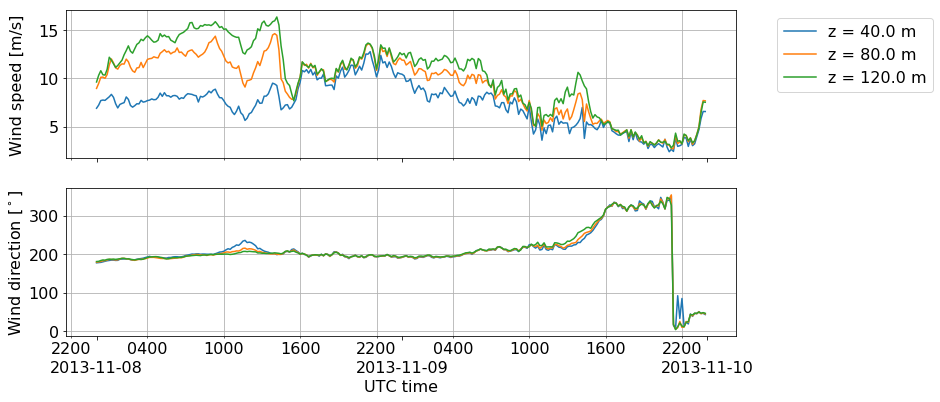

In [11]:
fig,ax = plot_timehistory_at_height(df10,
                                    fields = ['wspd','wdir'],
                                    heights = [40,80,120]
                                   )

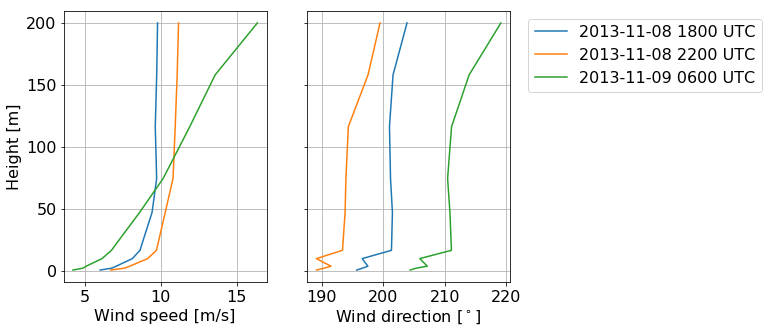

In [12]:
fig,ax = plot_profile(df10,
                      fields = ['wspd','wdir'],
                      times = ['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 6:00:00'],
                     )

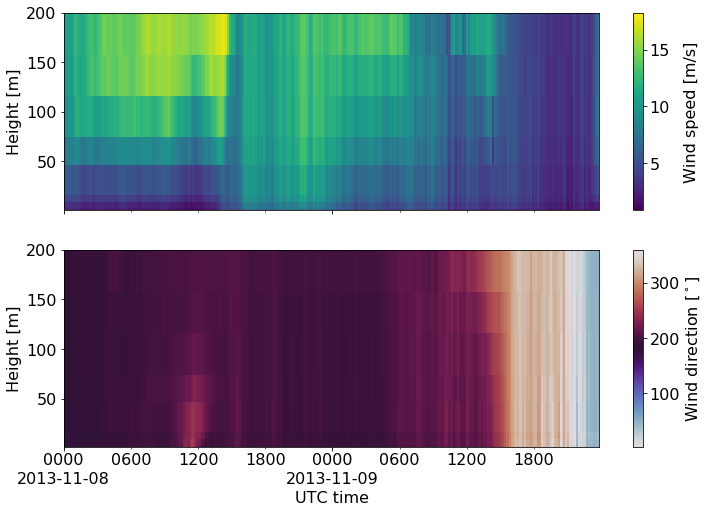

In [13]:
fig,ax,cbar = plot_timeheight(df10,fields = ['wspd','wdir'])

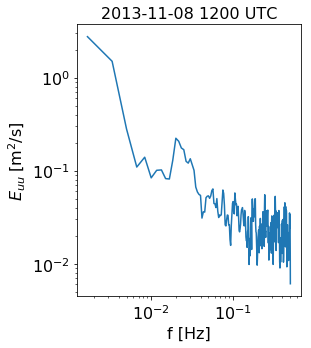

In [14]:
fig,ax = plot_spectrum(df_spectra,
                       fields = 'u',
                       times  = '2013-11-08 12:00:00',
                      )

## Advanced plotting examples

Plot timehistory at all TTU heights using a custom colormap

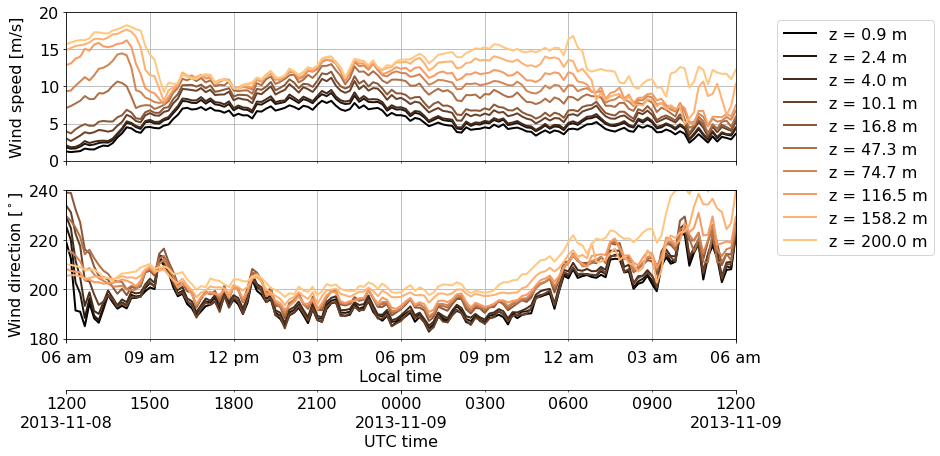

In [15]:
fig,ax,ax2 = plot_timehistory_at_height(df10, fields = ['wspd','wdir'], heights = 'all',
                                    # Specify field limits
                                    fieldlimits={'wspd':(0,20),'wdir':(180,240)},
                                    # Specify time limits
                                    timelimits=('2013-11-08 12:00:00','2013-11-09 12:00:00'),
                                    # Specify colormap
                                    cmap='copper',
                                    # Plot local time axis
                                    plot_local_time=True, local_time_offset=-6,
                                    # Additional keyword arguments to personalize plotting style
                                    linewidth=2,linestyle='-',marker=None,
                                   )

#Move xs tick down slightly to avoid overlap with y ticks in ax[1]
ax[-1].tick_params(axis='x', which='minor', pad=10)

# Adjust xaxis tick locations of UTC time axis
ax2.xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))

Compare instantaneous profiles with 10-min averaged profiles.

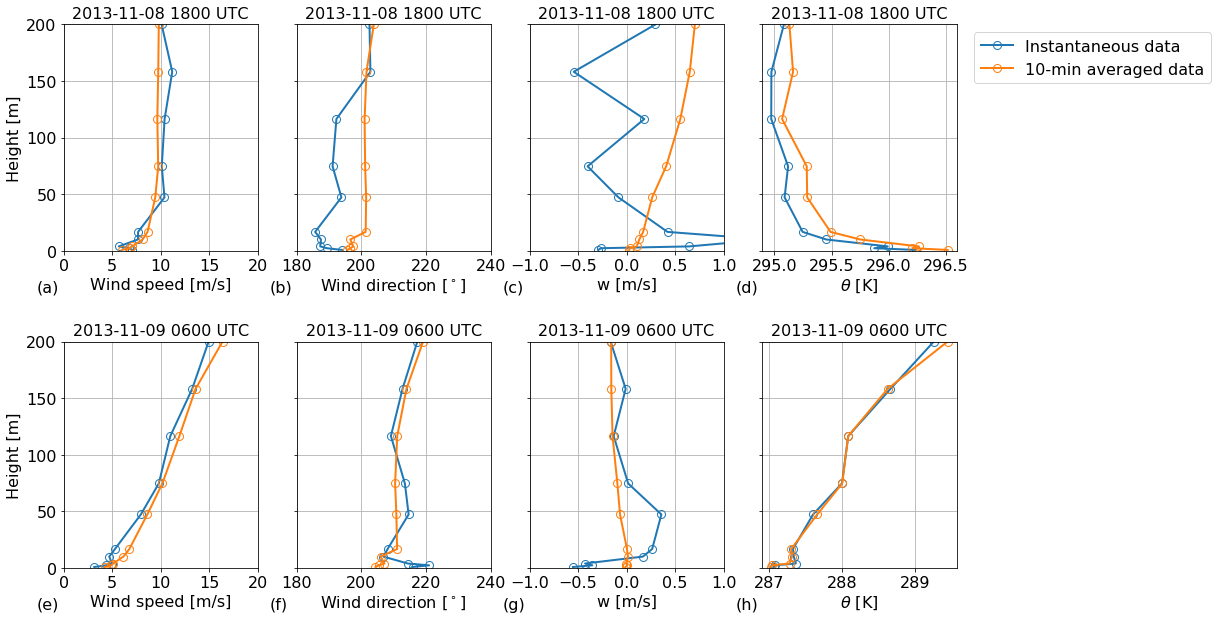

In [16]:
fig,ax = plot_profile(datasets={'Instantaneous data':df,'10-min averaged data':df10},
                      fields=['wspd','wdir','w','theta'],
                      times=['2013-11-08 18:00:00','2013-11-09 06:00:00'],
                      # Specify field limits
                      fieldlimits={'wspd':(0,20),'wdir':(180,240),'w':(-1,1)},
                      # Specify height limits
                      heightlimits=(0,200),
                      # Stack results by dataset instead of times
                      stack_by_datasets=True,
                      # Specify custom field labels
                      fieldlabels={'w':'w [m/s]'},
                      # Label subplots
                      labelsubplots=True,
                      # Change field order to have different fields correspond to different columns instead of rows
                      fieldorder='F',
                      # Additional keyword arguments to personalize plotting style
                      linewidth=2,marker='o',markersize=8,mfc="none",
                     )